# Histopathologic Cancer Detection 

Lets just start with some imports straight away

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import seaborn as sns 
from sklearn.utils import shuffle
import logging
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adadelta

from pyspark.sql import SparkSession

logger = logging.getLogger()

## Purpose and goal definition

Our purpose is to be able to identify metastatic cancer in small image patches taken from larger digital pathology scans, specifically of lymph node sections. Both of us were highly interested in medical, preferebly brain problem, but after not finding a good enough dataset on kaggle for brain pathologies we decided to go with the Histopathologic Cancer Detection dataset which spiked our interest. 

We believe solving these groups of problems is highly important. Being able to detect cancer using an algorithem can potentially shorten detection and diagnosis times, reduce human error and subsequentially save patient lives and reduce further complications.

### So why is solving the Histopathologic Cancer Detection dataset challenge so important?
The **lymph system** is a part of our immune system. It includes a network of lymph vessels and nodes. Lymph vessels are a lot like the veins that collect and carry blood through the body. But instead of carrying blood, these vessels carry the clear watery fluid called lymph. Lymph fluid also contains white blood cells, which help fight infections.

Cancer can appear in the lymph nodes in 2 ways: 
* start there (lymphoma)
* spread there from somewhere else.

In the case of this project it doesn't matter to us if it started there or spread there, the question is, is it there or not. 

Generally speaking, cancer in lymph nodes is hard to find. Normal lymph nodes are tiny and can be hard to find as is, but when there’s any kind of infection, inflammation, or cancer, the nodes can get larger. Those near the body’s surface often get big enough to feel with your fingers, and some can even be seen. But if there are only a few cancer cells in a lymph node, it may look and feel normal. Lymph nodes deep in the body cannot be felt or seen. **Essentially the only way to know whether there is cancer in a lymph node is to do a biopsy**. 

**Histopathology** is the diagnosis and study of diseases of the tissues in order to study the manifestation of different deseases, including cancer. It involves examining tissues and cells under a microscope, **a biopsy**. Histopathologists are doctors who are responsible for that study and the diagnoses that follows, they help clinicians manage a patient's care.

As we can assume, manual detection of a cancer cell is a tiresome task and involves human error. Most parts of the cell are frequently part of irregular random and arbitrary visual angles. As we already mentioned, the only way to detect cancer in a lymph node is using a biopsy. Machine learning algorithems can be applied to obtain better results as compared with manual pathological detection systems, this means that solving this challenge can be cruicial for lymph node cancer patients.  

**The goal** is to identify whether a tumor is benign or of a malignant in nature, malignant tumors are cancerous, which means they should be treated as soon as possible to reduce and prevent further complications. In other words we are dealing with a **binary classification problem**. 

## Data collection

Data was collected directly from [Kaggle](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data). It's a slightly modified version of the PCam dataset that can be found right [here](https://github.com/basveeling/pcam). The difference between the Kaggle version and the PCam version is that the PCam version contains duplications due to it's probabalistic sampling. 

In [2]:
spark = SparkSession \
    .builder \
    .appName("DSProject") \
    .master("local[*]") \
    .getOrCreate()

22/06/11 00:06:15 WARN Utils: Your hostname, Simonas-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.1 instead (on interface en0)
22/06/11 00:06:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/11 00:06:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
X_data_directory = "../../data/histopathologic-cancer-detection/train/"
y_data_directory = "../../data/histopathologic-cancer-detection/train_labels.csv"

data_to_predict_directory = "../../data/histopathologic-cancer-detection/test"

In [4]:
y_data_directory

'../../data/histopathologic-cancer-detection/train_labels.csv'

In [5]:
y_df = spark.read.option("header", "true").csv(y_data_directory)

We're not going to load the tif images themselfs into a dataframe. 
* Spark image source doesn't handle tif format. So we'd need to use binary format
* The data in question caused an out of memory exception :(

In [130]:
# X_df = spark.read.format("binaryFile").option("pathGlobFilter", "*.tif").load(X_data_directory)

SyntaxError: invalid syntax (275044889.py, line 1)

In [145]:
y_df.show(truncate=False)

+----------------------------------------+-----+
|id                                      |label|
+----------------------------------------+-----+
|f38a6374c348f90b587e046aac6079959adf3835|0    |
|c18f2d887b7ae4f6742ee445113fa1aef383ed77|1    |
|755db6279dae599ebb4d39a9123cce439965282d|0    |
|bc3f0c64fb968ff4a8bd33af6971ecae77c75e08|0    |
|068aba587a4950175d04c680d38943fd488d6a9d|0    |
|acfe80838488fae3c89bd21ade75be5c34e66be7|0    |
|a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da|1    |
|7f6ccae485af121e0b6ee733022e226ee6b0c65f|1    |
|559e55a64c9ba828f700e948f6886f4cea919261|0    |
|8eaaa7a400aa79d36c2440a4aa101cc14256cda4|0    |
|a106469bbfda4cdc5a9da7ac0152927bf1b4a92d|0    |
|c3d660212bf2a11c994e0eadff13770a9927b731|1    |
|a1991e73a9b676faddd2bd47c39754b14d1eb923|0    |
|08566ce82d4406f464c9c2a3cd014704735db7a9|0    |
|94fa32b29cc1c00403176c0795fffa3cfaa0f20e|1    |
|f416de7491a31951f79b3cee75b002f4d1bf0162|0    |
|a1c001f6b242c72d3066f15ac6eb059ea72d30ba|0    |
|0b820b71670c039dd0a

In [142]:
y_df.count()

220025

In [143]:
y_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- label: string (nullable = true)



In [97]:
y = pd.read_csv("../../data/histopathologic-cancer-detection/train_labels.csv")

In [98]:
y.shape

(220025, 2)

In [99]:
y.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


### Sort labels in alphanumeric order

In [6]:
y_sorted_df = y_df.orderBy('id')

In [7]:
y_sorted_df.show(truncate=False)

+----------------------------------------+-----+
|id                                      |label|
+----------------------------------------+-----+
|00001b2b5609af42ab0ab276dd4cd41c3e7745b5|1    |
|000020de2aa6193f4c160e398a8edea95b1da598|0    |
|00004aab08381d25d315384d646f5ce413ea24b1|0    |
|0000d563d5cfafc4e68acb7c9829258a298d9b6a|0    |
|0000da768d06b879e5754c43e2298ce48726f722|1    |
|0000f8a4da4c286eee5cf1b0d2ab82f979989f7b|0    |
|00010f78ea8f878117500c445a658e5857f4e304|0    |
|00011545a495817817c6943583b294c900a137b8|0    |
|000126ec42770c7568204e2f6e07eb9a07d5e121|0    |
|00014e39b5df5f80df56f18a0a049d1cc6de430a|1    |
|00016a638ed77529609ac61479dc7ee99a6f3711|0    |
|0001a2bc5d4aa55989f014bfad74a95ac3dfff54|1    |
|0001b13d0d0f66d147a4167fca19fe22721556d4|0    |
|00027298de60883932506d5c46be978d71a2da68|1    |
|0002b6bb08e7520917c302addd291000b670069c|0    |
|0002d959eecbd8d7f6614fdd513154e8e0e8e964|1    |
|00030ae10b490d6f1b114bd7ea7a222889e61baa|0    |
|0003378267bd3d9964d

In [7]:
y_sorted = y.sort_values('id')

NameError: name 'y' is not defined

In [12]:
y_sorted.head()

,id,label
151577,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1
16166,000020de2aa6193f4c160e398a8edea95b1da598,0
87832,00004aab08381d25d315384d646f5ce413ea24b1,0
69359,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0
128953,0000da768d06b879e5754c43e2298ce48726f722,1


In [13]:
y_sorted.tail()

,id,label
175454,fffe6c73afcf5f5da5818fb70cb723026b172eca,0
168161,fffeb3f5361ea57e728fb689e6be34d07d16ca7e,0
39707,fffeca85b16452a7709d163e05a70e646782b3cc,1
208140,fffeeb1297fd4e26f247af648a2a6f942dfa2e9d,1
129173,ffffe55093358954f38bba4c35b6aa0ece86177c,0


### Preprocess labels so we'd be able to use them for loading and visualizing images 

In [7]:
from pyspark.sql.types import IntegerType,BooleanType,DateType
from pyspark.sql.functions import lit, concat, col

In [8]:
y_trs_df = y_sorted_df.withColumn('translated_label',y_sorted_df["label"].cast(BooleanType()))

In [22]:
y_trs_df.show(truncate=False)

+----------------------------------------+-----+----------------+
|id                                      |label|translated_label|
+----------------------------------------+-----+----------------+
|00001b2b5609af42ab0ab276dd4cd41c3e7745b5|1    |true            |
|000020de2aa6193f4c160e398a8edea95b1da598|0    |false           |
|00004aab08381d25d315384d646f5ce413ea24b1|0    |false           |
|0000d563d5cfafc4e68acb7c9829258a298d9b6a|0    |false           |
|0000da768d06b879e5754c43e2298ce48726f722|1    |true            |
|0000f8a4da4c286eee5cf1b0d2ab82f979989f7b|0    |false           |
|00010f78ea8f878117500c445a658e5857f4e304|0    |false           |
|00011545a495817817c6943583b294c900a137b8|0    |false           |
|000126ec42770c7568204e2f6e07eb9a07d5e121|0    |false           |
|00014e39b5df5f80df56f18a0a049d1cc6de430a|1    |true            |
|00016a638ed77529609ac61479dc7ee99a6f3711|0    |false           |
|0001a2bc5d4aa55989f014bfad74a95ac3dfff54|1    |true            |
|0001b13d0

In [8]:
y_trs_df = y_trs_df.withColumn('file_name',concat(lit(X_data_directory),y_sorted_df["id"],lit("tif")))

NameError: name 'y_trs_df' is not defined

In [10]:
y_trs_df.show(truncate=False)

+----------------------------------------+-----+----------------+---------------------------------------------------------------------------------------------+
|id                                      |label|translated_label|file_name                                                                                    |
+----------------------------------------+-----+----------------+---------------------------------------------------------------------------------------------+
|00001b2b5609af42ab0ab276dd4cd41c3e7745b5|1    |true            |../../data/histopathologic-cancer-detection/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5tif|
|000020de2aa6193f4c160e398a8edea95b1da598|0    |false           |../../data/histopathologic-cancer-detection/train/000020de2aa6193f4c160e398a8edea95b1da598tif|
|00004aab08381d25d315384d646f5ce413ea24b1|0    |false           |../../data/histopathologic-cancer-detection/train/00004aab08381d25d315384d646f5ce413ea24b1tif|
|0000d563d5cfafc4e68acb7c9829258a298d9b6

In [100]:
y_sorted.loc[y_sorted['label'] == 0,'translated_label'] = 'False'
y_sorted.loc[y_sorted['label'] == 1,'translated_label'] = 'True'

y_sorted["file_name"] = y_sorted["id"].astype(str) + ".tif"

In [101]:
y_sorted.head()

,id,label,translated_label,file_name
151577,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1,True,00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif
16166,000020de2aa6193f4c160e398a8edea95b1da598,0,False,000020de2aa6193f4c160e398a8edea95b1da598.tif
87832,00004aab08381d25d315384d646f5ce413ea24b1,0,False,00004aab08381d25d315384d646f5ce413ea24b1.tif
69359,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0,False,0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif
128953,0000da768d06b879e5754c43e2298ce48726f722,1,True,0000da768d06b879e5754c43e2298ce48726f722.tif


## Data visualization

As written in the description of the github repository a positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable the design of fully-convolutional models that do not use any zero-padding, to ensure consistent behavior when applied to a whole-slide image. This essentially means that we can maybe crop the images and see how this influences accuracy. For now we'll keep the image as is.

In the original dataset the labels were balances between True and False and also contained information regarding the cancer in general (ie Is it cancerour? Is only the center canceros?). Kaggle removed that extra bit of information and in addition removed duplicates from the dataset.


In [15]:
pandas_y_df = y_trs_df.to_pandas_on_spark(index_col="id")

In [16]:
y_sorted.count()

id                  220025
label               220025
translated_label    220025
file_name           220025
dtype: int64

We can see that there are indeed no duplicates, even after dropping duplications the data stayed the same.

In [17]:
y_sorted.drop_duplicates()

,id,label,translated_label,file_name
151577,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1,True,00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif
16166,000020de2aa6193f4c160e398a8edea95b1da598,0,False,000020de2aa6193f4c160e398a8edea95b1da598.tif
87832,00004aab08381d25d315384d646f5ce413ea24b1,0,False,00004aab08381d25d315384d646f5ce413ea24b1.tif
69359,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0,False,0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif
128953,0000da768d06b879e5754c43e2298ce48726f722,1,True,0000da768d06b879e5754c43e2298ce48726f722.tif
...,...,...,...,...
175454,fffe6c73afcf5f5da5818fb70cb723026b172eca,0,False,fffe6c73afcf5f5da5818fb70cb723026b172eca.tif
168161,fffeb3f5361ea57e728fb689e6be34d07d16ca7e,0,False,fffeb3f5361ea57e728fb689e6be34d07d16ca7e.tif
39707,fffeca85b16452a7709d163e05a70e646782b3cc,1,True,fffeca85b16452a7709d163e05a70e646782b3cc.tif
208140,fffeeb1297fd4e26f247af648a2a6f942dfa2e9d,1,True,fffeeb1297fd4e26f247af648a2a6f942dfa2e9d.tif


There are no duplicates based purely on image id either

In [18]:
y_sorted.groupby('id').filter(lambda x: len(x) > 1)

,id,label,translated_label,file_name


In [18]:
pandas_y_df

,label,translated_label,file_name
id,,,
00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1,True,../../data/histopathologic-cancer-detection/tr...
000020de2aa6193f4c160e398a8edea95b1da598,0,False,../../data/histopathologic-cancer-detection/tr...
00004aab08381d25d315384d646f5ce413ea24b1,0,False,../../data/histopathologic-cancer-detection/tr...
0000d563d5cfafc4e68acb7c9829258a298d9b6a,0,False,../../data/histopathologic-cancer-detection/tr...
0000da768d06b879e5754c43e2298ce48726f722,1,True,../../data/histopathologic-cancer-detection/tr...


### Visualizing class labels distribution

In [25]:
pandas_y_df.plot.bar()

ImportError: plotly is required for plotting when the default backend 'plotly' is selected.

In [20]:
sns.countplot(data=y_sorted, x='translated_label')

NameError: name 'y_sorted' is not defined

We can see that after removing the duplications we have a bit of a skew between the labels. There are slightly more False labels than True labels. Lets look at the skew metric

In [20]:
y_sorted['label'].skew()

0.38692104417661555

We can see that the metric shows us that the labels distribution is fairly symmetrical. We'll keep it as is, and use oversampling in case we see problems with this balance in the future.

In [21]:
file_name = y_sorted.iloc[[0]]['file_name'].iloc[0]
file_path = f"{X_data_directory}{file_name}"

img = plt.imread(file_path)

img.shape

(96, 96, 3)

From the shape we can see that our images are 96x96 with three color channels. Lets visualy some images and their labels. Since a positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue we'll circle the 32x32 center with a patch. A blue color for negative and a red color for positive.

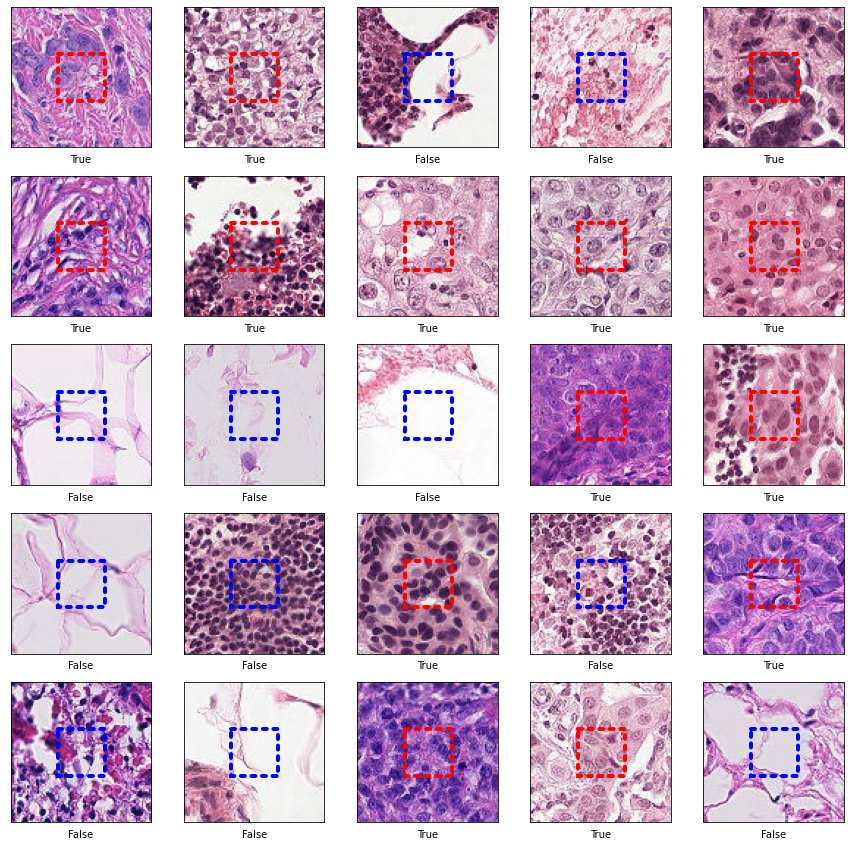

In [93]:
fig, ax = plt.subplots(5,5,figsize=(15,15))

shuffled_data = shuffle(y_sorted)

for (i,current_subplot) in zip(range(25),ax.flat):
    current_row = shuffled_data.iloc[[i]]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # get file name from cell
    current_file_name = current_row['file_name'].iloc[0]
    
    # concat to full path
    curr_file_path = f"{X_data_directory}{current_file_name}"
    
    try:
        # read image and add to plot
        img = plt.imread(curr_file_path)
        current_subplot.imshow(img)
        
        current_label = current_row['translated_label'].iloc[0]
        
        if (current_label == 'True'):
            current_patch_color = 'r'
        else:
            current_patch_color = 'b'
        
        # create patch recatangle around the suspected area
        box = patches.Rectangle((32,32),32,32, linewidth=4, edgecolor=current_patch_color, facecolor='none', linestyle=':', capstyle='round')
        
        # add labels and patch 
        current_subplot.xaxis.label.set_text(current_row['translated_label'].iloc[0])
        current_subplot.add_patch(box)
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()


### Exploring low/high contract images

In [104]:
from skimage.exposure import is_low_contrast

In [25]:
def is_low_contrast_func(file_name):
    return is_low_contrast(plt.imread(f'{X_data_directory}{file_name}'), fraction_threshold=0.3)

In [26]:
y_sorted['is_low_contrast'] = y_sorted['file_name'].apply(func=is_low_contrast_func)

<AxesSubplot:xlabel='is_low_contrast', ylabel='count'>

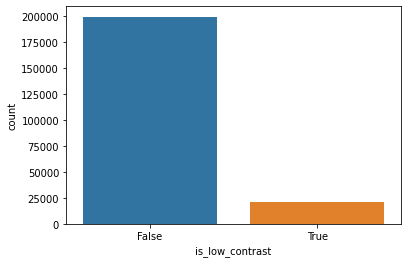

In [27]:
sns.countplot(data=y_sorted, x='is_low_contrast')

In [28]:
y_sorted.sort_values(['is_low_contrast']).tail()

,id,label,translated_label,file_name,is_low_contrast
210840,5eacf07fb2167c7bef34787a7b8481dc7936e547,0,False,5eacf07fb2167c7bef34787a7b8481dc7936e547.tif,True
208416,218a405c52d67579decc3ae548dcad83fe266623,1,True,218a405c52d67579decc3ae548dcad83fe266623.tif,True
194203,980fa63443b3625a4ce17e4a58ea350d0899ef41,0,False,980fa63443b3625a4ce17e4a58ea350d0899ef41.tif,True
204638,5eb8ed482d161f30b5d83120348c8452340af080,0,False,5eb8ed482d161f30b5d83120348c8452340af080.tif,True
59514,7a0f68780244d9df830348fe6b49ec9f62f22809,0,False,7a0f68780244d9df830348fe6b49ec9f62f22809.tif,True


In [29]:
low_contrast_img_df = y_sorted[y_sorted['is_low_contrast'] == True]

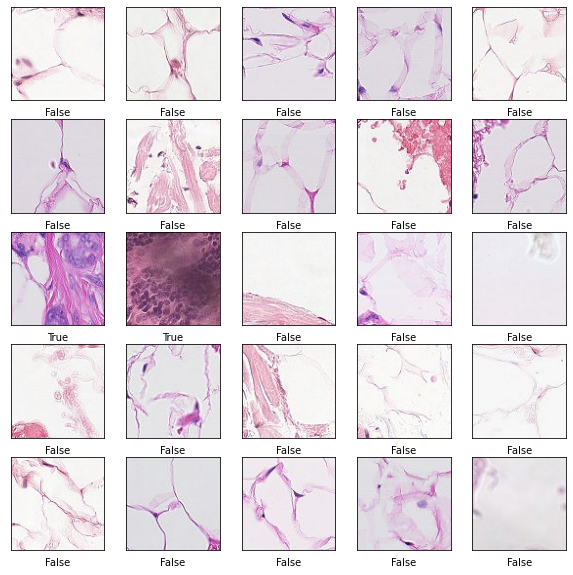

In [30]:
plt.figure(figsize=(10,10))

for i in range(25):
    current_row = low_contrast_img_df.iloc[[i]]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # get file name from cell
    current_file_name = current_row['file_name'].iloc[0]
    
    # concat to full path
    curr_file_path = f"{X_data_directory}{current_file_name}"
    
    try:
        img = plt.imread(curr_file_path)
        plt.imshow(img)

        plt.xlabel(current_row['translated_label'].iloc[0])
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()

To the naked eye it seems that the threshold of 0.3 is too high. Let's try lowering that threshold.

In [105]:
def is_low_contrast_func_01(file_name):
    return is_low_contrast(plt.imread(f'{X_data_directory}{file_name}'), fraction_threshold=0.1)

In [106]:
y_sorted['is_low_contrast_01'] = y_sorted['file_name'].apply(is_low_contrast_func_01)

<AxesSubplot:xlabel='is_low_contrast_01', ylabel='count'>

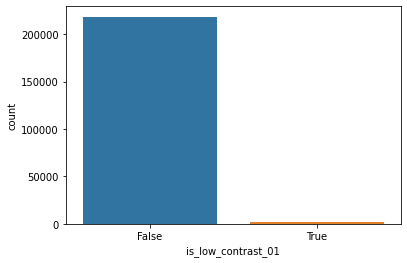

In [107]:
sns.countplot(data=y_sorted, x='is_low_contrast_01')

In [108]:
low_contrast_img_df = y_sorted[y_sorted['is_low_contrast_01'] == True]

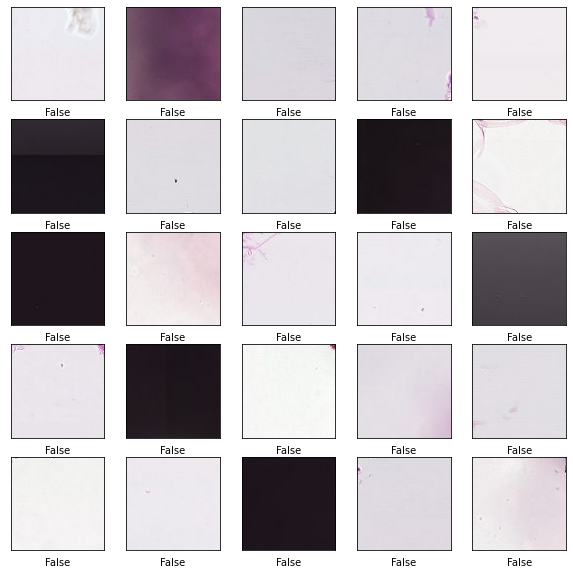

In [109]:
plt.figure(figsize=(10,10))

for i in range(25):
    current_row = low_contrast_img_df.iloc[[i]]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # get file name from cell
    current_file_name = current_row['file_name'].iloc[0]
    
    # concat to full path
    curr_file_path = f"{X_data_directory}{current_file_name}"
    
    try:
        img = plt.imread(curr_file_path)
        plt.imshow(img)

        plt.xlabel(current_row['translated_label'].iloc[0])
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()

## Load image train set

The data format we're dealing with here if tif. For this reason we can't use the image_dataset_from_directory provided by Keras. Instead we're going to use the ImageDataGenerator with

In [8]:
from keras.preprocessing.image import ImageDataGenerator

#### The image data generator is going to rescale the images, deviding them by 255 so that pixel value ranges between 0 and 1

In [14]:
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.3,
                             width_shift_range=4,  # randomly shift images horizontally
                             height_shift_range=4,  # randomly shift images vertically 
                             horizontal_flip=True,  # randomly flip images
                             vertical_flip=True)  # randomly flip image

In [60]:
batch_size=32

In [61]:
train_set = datagen.flow_from_dataframe(
        dataframe=y_sorted,
        directory=X_data_directory,
        x_col='file_name',
        y_col='translated_label',
        shuffle=True,
        seed=42, 
        batch_size=batch_size,
        validation_split=0.3,
        subset="training",
        class_mode='binary',
        target_size=(96,96)) 



Found 154018 validated image filenames belonging to 2 classes.


In [62]:
val_set = datagen.flow_from_dataframe(
        dataframe=y_sorted,
        directory=X_data_directory,
        x_col='file_name',
        y_col='translated_label',
        shuffle=True,
        seed=42,
        batch_size=batch_size,
        validation_split=0.3,
        subset="validation",
        class_mode='binary',
        target_size=(96,96)) 

Found 66007 validated image filenames belonging to 2 classes.


### Determining the size of the batch
So at this point we've actually got a pretty ugly exception if we'd set the batch size to be any number aside from 1. But then also not setting "steps_per_epoch" would put us in a bad position. 

Calculating the following metrics proves to be the same as len(train_set). So using this setting the "steps_per_epoch" is running a single image per set per the entire dataset. 

We then discovered that this exception was actually encountered because we didn't set the target_size=(96,96) in the previous section! We assumed that not setting target size would take the original image size, which is, (96,96). That assumption was clearly wrong.

In [63]:
train_steps_per_epoch = np.ceil(train_set.n / train_set.batch_size)
val_set_per_epoch = np.ceil(val_set.n/ val_set.batch_size)

In [64]:
train_steps_per_epoch

4814.0

In [65]:
len(train_set)

4814

## Building our model

In [66]:
model = models.Sequential()
model.add(layers.Input(shape=(96, 96, 3)))

model.add(layers.Conv2D(16, (3, 3)))
model.add(layers.BatchNormalization(axis = 3))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.BatchNormalization(axis = 3))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization(axis = 3))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [67]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 batch_normalization_15 (Bat  (None, 94, 94, 16)       64        
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 94, 94, 16)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 47, 47, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 batch_normalization_16 (Bat  (None, 45, 45, 32)      

## Compiling and fitting our model

In [68]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Notice no batch size and validation batch size are specified since our data is in the form of generator, and they already generate batches.

In [71]:
history = model.fit(train_set, epochs=5, steps_per_epoch=len(train_set),
                    validation_data=val_set,verbose=1)

Epoch 1/5
4814/4814 [==============================] - 1096s 228ms/step - loss: 0.4064 - accuracy: 0.8240 - val_loss: 0.4140 - val_accuracy: 0.7816
Epoch 2/5
4098/4814 [========================>.....] - ETA: 2:15 - loss: 0.3733 - accuracy: 0.8474

KeyboardInterrupt: 

Looking at the first epoch we've noticed the loss and accuracy don't really change afte raround 50-60K images